<a href="https://colab.research.google.com/github/OmPanchal/AlexNet-using-tensorflow/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [**AlexNet**](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

**Initial high level plan**

A list of the key pieces and my thoughts of their implementation in this project, **before a throughrough read through of the paper**:
* *Dataset* - [ImageNet](https://www.image-net.org/download.php). Given its immense size, there may be a possibility that a subset of the dataset will need to be implemented, due to the limitations of RAM of the standard colab runtime. Implementation will be done with the tensorflow Data API.
* Local Response Normalisation: After an overview of the paper, this seems to be the main differentiating factor of AlexNet. With the inital glance of the its definition, it seems possible to implement using tensorflow functions. However a more efficient implementation is not clear...

**Thoughts after reading the paper ...**
* >ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories
* The Dataset will definitely need to be a subset of ImageNet.
* Another component of the model which was missed out during my initial overveiw of the paper was the augmenting of data and the changing of the size of the images before they are inputted into the model.
* The augmentation consists of taking patches of the image, as well as PCA on the RGB values of the images (which at the moment seems to be the most complex calculation).
* Smaller details such as the values used for data normalisation and the methods used for the optimisation of the network will be taken into account.

Overall the largest change to my initial plan of this project has been the size of data which the network will need to be trained on, given the immense size of the Imagenet Dataset. As well as this perhaps a simpler version of the Colour data augmenation may need to be used, due to my limted understanding of PCA and dimensionality reduction...

## **Imports**

In [1]:
import tensorflow as tf
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import time

## **Dataset (ImageNet - *Subset*)**

In [2]:
# Download the dataset from kaggle
dataset_path = "akash2sharma/tiny-imagenet"
dataset_name = "tiny-imagenet"

!pip install kaggle --quiet

!mkdir ~/.kaggle/
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d {dataset_path} --quiet

!mkdir data
!unzip -qq {dataset_name + ".zip"} -d data

In [3]:
!rm -r /content/data/tiny-imagenet-200/tiny-imagenet-200
!rm -r /content/tiny-imagenet.zip

In [4]:
# mapping of the label codes and the labels to make is easier to identify them...
CODE_LABEL_MAPPING = {}

label_codes = os.listdir("/content/data/tiny-imagenet-200/train")

with open("/content/data/tiny-imagenet-200/words.txt", "r") as f:
    for label_string in f.readlines():
        _ = label_string.strip().split("\t")
        if _[0] in label_codes:
            CODE_LABEL_MAPPING[_[0]] = _[1]

LABELS_LIST = list(CODE_LABEL_MAPPING.values())
CODES_LIST = list(CODE_LABEL_MAPPING.keys())

CODE_LABEL_MAPPING

{'n01443537': 'goldfish, Carassius auratus',
 'n01629819': 'European fire salamander, Salamandra salamandra',
 'n01641577': 'bullfrog, Rana catesbeiana',
 'n01644900': 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'n01698640': 'American alligator, Alligator mississipiensis',
 'n01742172': 'boa constrictor, Constrictor constrictor',
 'n01768244': 'trilobite',
 'n01770393': 'scorpion',
 'n01774384': 'black widow, Latrodectus mactans',
 'n01774750': 'tarantula',
 'n01784675': 'centipede',
 'n01855672': 'goose',
 'n01882714': 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'n01910747': 'jellyfish',
 'n01917289': 'brain coral',
 'n01944390': 'snail',
 'n01945685': 'slug',
 'n01950731': 'sea slug, nudibranch',
 'n01983481': 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 'n02002724': 'black stork, Ciconia nigra',
 'n02056570': 'ki

In [5]:
TRAIN_DS = tf.keras.utils.image_dataset_from_directory("/content/data/tiny-imagenet-200/train").unbatch()

# preprocess the data - the data has already been cropped and resized appropriately...
# Therefore all there is needed to do is to normalise the rgb values such that they are between 0 and 1
def preprocess(image):
    return tf.cast(image / 255, dtype=tf.float32)

TRAIN_DS = TRAIN_DS.map(lambda image, label: (preprocess(image), label))
TRAIN_DS = TRAIN_DS.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
TRAIN_DS = TRAIN_DS.batch(32)

TRAIN_DS

Found 100000 files belonging to 200 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

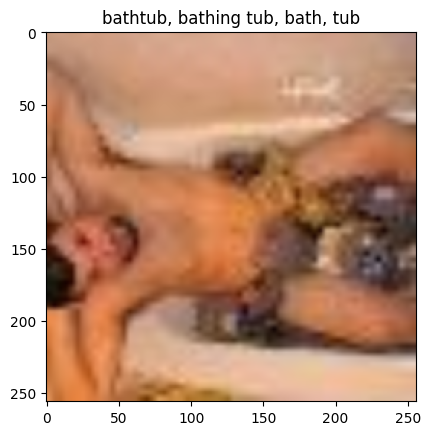

In [6]:
_img = next(TRAIN_DS.as_numpy_iterator())

plt.title(LABELS_LIST[_img[1][0]])
plt.imshow(_img[0][0])

## **Model Internals**

### Local Response Normalisation Initial Build

In [ ]:
# Test build of LRN

depth = 5

# initial build
#                   x   y   depth..
_a = tf.Variable(tf.ones(shape=(12, 12, depth)) + tf.constant(list(range(depth)), dtype="float32")[tf.newaxis, tf.newaxis])

_k = 2
_n = 5
_alpha = 10e-4
_beta = 0.75
_N = _a.shape[-1]
_i = 0


ITERATIVE_TEST_TIMES = []

# Run 10 times and find average time taken

for i in range(10):
    start = time.time()
    for i in range(depth):
        for x in range(_a.shape[0]):
            for y in range(_a.shape[1]):
                _max = tf.cast(tf.reduce_min((_N, tf.math.ceil(i + (_n / 2)))), dtype="int32")
                _min = tf.cast(tf.reduce_max((0, tf.math.ceil(i - (_n / 2)))), dtype="int32")

                _b = _a[x, y, i] / ((_k + (_alpha * (tf.reduce_sum((_a[x, y][_min: _max]) ** 2)))) ** _beta)

                _a[x, y].assign(_b)

    ITERATIVE_TEST_TIMES.append(time.time() - start)

TEST_AVG_ITER = sum(ITERATIVE_TEST_TIMES) / len(ITERATIVE_TEST_TIMES)

print("AVERAGE TIME", TEST_AVG_ITER, "s")

AVERAGE TIME 2.860633969306946 s


As mentioned in the paper, the excitement of the neurones around the the ith activation in position (x, y) is inhibited by the activation of the neurones around it (lateral inhibition), however this implementation is only for one set of (x, y) values therefore, for it to be practical, a for loop would have to be used. However having 2 for loops to loop through every (x, y) value would be slow. A possible solution to this could be the use of an operation similar to the convolution operation, where a filter of size `n` slider across the (x, y) values and performs the operation described in the LRN formula (sqare and sum). It would then be scaled by `alpha`,`k` would be added to it and the sum would be put to the power of `beta`. Finally the original matrix (the feature map) would be dived by this calculated matrix.

In [ ]:
# implementation idea (1): subclass the conv2d layer from keras
# set the kernels to 1s, therefore no value in the origional value is scaled
# instead of convolving with the originoal feature map, convolve with the square of the feature map
# scale the values with the hyper parameters
# divide the original feauture map by the calculated value

class TESTLRN(tf.keras.layers.DepthwiseConv2D):
    def __init__(self, n=5, **kwargs):
        super().__init__(kernel_size=(n, 1),
                         strides=1,
                         padding="SAME",
                         depthwise_initializer='ones',
                         use_bias=False
                         )
        self.n = n
        self.k = 2
        self.alpha = 10e-4
        self.beta = 0.75
        self.trainable = False

    def build(self, input_shape):
        # input the transpose tensor shape so that the kernels are appropriately initialised.
        print("[BUILD] INITIAL INPUT SHAPE", input_shape)
        print("[BUILD] TRANSPOSED INPUT SHAPE", (input_shape[0] + input_shape[1:][::-1]))
        print("[BUILD] INTERPRETED KERNEL SHAPE: ", (self.n, 1, (input_shape[0] + input_shape[1:][::-1])[-1], 1))
        # super().build((input_shape[0] + input_shape[1:][::-1]))

        # Therefore this implementation will remove the need for any tranposing operation to happen outside of the layer...
        # Everthing will be kept inernel
        super().build(input_shape) # so that the layer expects the non transposed input
        self.depthwise_kernel = tf.ones(shape=(self.n, 1, input_shape[1], 1))

    def call(self, x):
        denom_sum = tf.transpose(super().call(tf.transpose(x, [0, 3, 2, 1]) ** 2), [0, 3, 2, 1])
        denom = (self.k + (self.alpha * denom_sum)) ** self.beta
        return x / denom

# print(L.__dict__.keys())
# print(L.depthwise_kernel)

# Repeat 10 times and find average time taken

LRN_TEST_DEPTH = 5
L = TESTLRN()
CONVOLUTIONAL_TEST_TIMES = []
lrn_test_inp = tf.ones(shape=(1, 12, 12, LRN_TEST_DEPTH)) + tf.constant(list(range(LRN_TEST_DEPTH)), dtype="float32")[tf.newaxis, tf.newaxis, tf.newaxis]

for i in range(10):
    start = time.time()
    L(lrn_test_inp)
    CONVOLUTIONAL_TEST_TIMES.append(time.time() - start)

TEST_AVG_CONV = sum(CONVOLUTIONAL_TEST_TIMES) / len(CONVOLUTIONAL_TEST_TIMES)
print("AVERAGE TIME", TEST_AVG_CONV, "s")

[BUILD] INITIAL INPUT SHAPE (1, 12, 12, 5)
[BUILD] TRANSPOSED INPUT SHAPE (1, 5, 12, 12)
[BUILD] INTERPRETED KERNEL SHAPE:  (5, 1, 12, 1)
AVERAGE TIME 0.003310966491699219 s


In [ ]:
print(f"The depthwise convolutional implementation is around {round(TEST_AVG_ITER / TEST_AVG_CONV)} times faster than the iterative approach...")

The depthwise convolutional implementation is around 864 times faster than the iterative approach...


### **Local Response Normalisation**

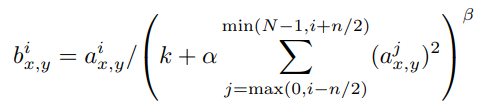

> *The constants k, n, α, and β are hyper-parameters whose values are determined using a validation set; we used k = 2, n = 5, α = 10−4, and β = 0.75.*

In [7]:
class LocalResponseNormalisation(tf.keras.layers.DepthwiseConv2D):
    def __init__(self, k=2, n=5, alpha=10e-4, beta=.75, **kwargs):
        super().__init__(kernel_size=(n, 1),
                         strides=1,
                         padding="SAME",
                         depthwise_initializer='ones',
                         use_bias=False,
                         **kwargs
                         )
        self.n = n
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.trainable = False

    def build(self, input_shape):
        super().build(input_shape)
        self.depthwise_kernel = tf.ones(shape=(self.n, 1, input_shape[1], 1))

    def call(self, x):
        denom_sum = tf.transpose(super().call(tf.transpose(x, [0, 3, 2, 1]) ** 2), [0, 3, 2, 1])
        denom = (self.k + (self.alpha * denom_sum)) ** self.beta
        return x / denom


### Data Augmentation Layer Initial Build

In [ ]:
crop_layer = tf.keras.layers.RandomCrop(244, 244)
def augment(image):
    return tf.image.random_flip_left_right(tf.image.random_crop(image, size=(244, 244, 3)))

test = TRAIN_DS.map(lambda image, label: (image, label))

Time taken to fetch:  4.929837703704834 s
Time taken to process 0.010224580764770508 s


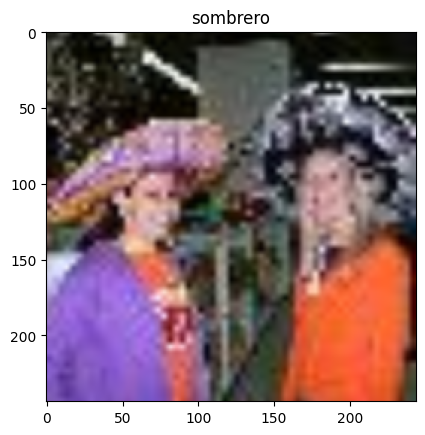

In [ ]:
next_time = time.time()
augment_test_image, augment_test_sample = next(test.unbatch().as_numpy_iterator())
print("Time taken to fetch: ", time.time() - next_time, "s")

augment_time = time.time()
augmented = augment(augment_test_image)
print("Time taken to process", time.time() - augment_time, "s")

plt.title(LABELS_LIST[augment_test_sample])
plt.imshow(augmented)

### **Data Augmentation**
>We do this by extracting random 224 × 224 patches (and their horizontal reflections) from the
256×256 images and training our network on these extracted patches

The implementation of this type of augmentation will be different from the one specified in the paper. It will take place during traning as a preprocessing layer only active during training, where all of the images will be randomly cropped, and **randomly flipped**. To ensure that both the origional image and the flipped image is trained on, the dataset will be repeated 3 times. This will increase the chance that both types of images will appear in training, as well as (hopefully) not overload the limited amount of RAM.

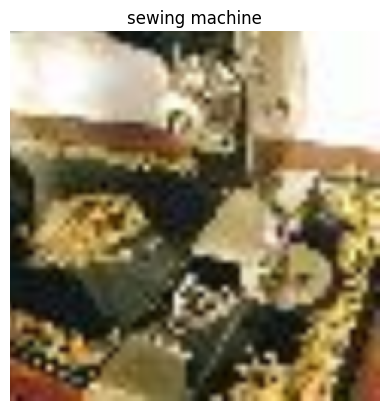

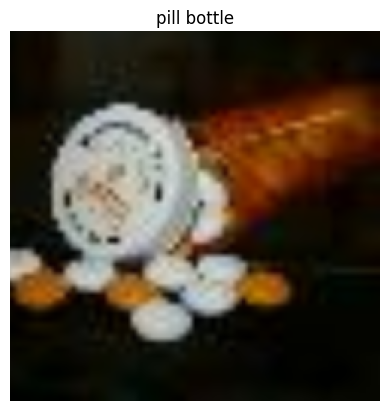

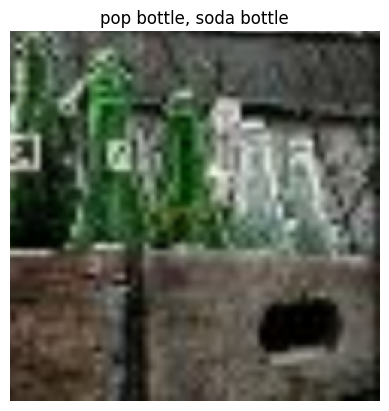

In [8]:
class CropFlip(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.random_crop = tf.keras.layers.RandomCrop(244, 244)

    def call(self, x, training):
        crop = self.random_crop(x)
        if training:
            return tf.image.random_flip_left_right(crop)
        else: return crop

augment_sample = next(TRAIN_DS.as_numpy_iterator())
augmented_images = CropFlip()(augment_sample[0], training=True)

for i in range(len(augmented_images[0][0:3])):
    plt.title(LABELS_LIST[augment_sample[1][i]])
    plt.axis("off")
    plt.imshow(augmented_images[i])
    plt.show()

### Model Architecture Initial Build

In [14]:
class TestModel(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.C1 = tf.keras.layers.Conv2D(filters=96,
                                         kernel_size=(11, 11),
                                         strides=4,
                                         activation="relu")
        self.LRN1 = LocalResponseNormalisation()
        self.MP1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)

        self.C2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5))
        self.LRN2 = LocalResponseNormalisation()
        self.MP2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)

        self.C3 = tf.keras.layers.Conv2D(filters=384,
                                         kernel_size=(3, 3),
                                         activation="relu")
        self.C4 = tf.keras.layers.Conv2D(filters=384,
                                         kernel_size=(3, 3),
                                         activation="relu")
        self.C5 = tf.keras.layers.Conv2D(filters=256,
                                         kernel_size=(3, 3),
                                         activation="relu")

        self.Flat = tf.keras.layers.Flatten()
        self.F1 = tf.keras.layers.Dense(4096, activation="relu")
        self.F2 = tf.keras.layers.Dense(4096, activation="relu")
        self.OUT = tf.keras.layers.Dense(200, activation="softmax")

    def call(self, x):
        x = self.C1(x)
        x = self.LRN1(x)
        x = self.MP1(x)

        x = self.C2(x)
        x = self.LRN2(x)
        x = self.MP2(x)

        x = self.C3(x)
        x = self.C4(x)
        x = self.C5(x)

        x = self.Flat(x)

        x = self.F1(x)
        x = self.F2(x)

        return self.OUT(x)


In [15]:
sampletestmodel = next(TRAIN_DS.take(1).as_numpy_iterator())[0]

In [16]:
test_model = TestModel()

out = test_model(CropFlip()(sampletestmodel))

test_model.summary()

Model: "test_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           multiple                  34944     
                                                                 
 local_response_normalisati  multiple                  0         
 on_2 (LocalResponseNormali                                      
 sation)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           multiple                  614656    
                                                                 
 local_response_normalisati  multiple                  0         
 on_3 (LocalResponseNormali                           

Looking at the summary of the network, the completeness of the network is ensured by its similarity in the number of parameters (close to 60 million)

In [17]:
out

<tf.Tensor: shape=(32, 200), dtype=float32, numpy=
array([[0.00501215, 0.00500543, 0.00499844, ..., 0.00500066, 0.00497844,
        0.00496452],
       [0.00501237, 0.00501104, 0.0049919 , ..., 0.00500292, 0.00497401,
        0.00495043],
       [0.00501489, 0.0050107 , 0.00499521, ..., 0.00499441, 0.00498136,
        0.00495521],
       ...,
       [0.00501516, 0.00502555, 0.00499725, ..., 0.00498449, 0.00497373,
        0.00495522],
       [0.00500116, 0.00500335, 0.00500106, ..., 0.00499709, 0.00498918,
        0.00496993],
       [0.00500441, 0.00501557, 0.00500503, ..., 0.00499041, 0.00498978,
        0.00495427]], dtype=float32)>

In [24]:
# training using model.fit

test_model.compile(
    optimizer="sgd",
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"]
)

da = CropFlip()

test_model.fit(TRAIN_DS.map(lambda im, la: ((da(im)), la)).take(1), epochs=5)

Epoch 1/5
1/1 [==============================] - 7s 7s/step - loss: 5.2987 - accuracy: 0.0312
Epoch 2/5
1/1 [==============================] - 8s 8s/step - loss: 5.2979 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 6s 6s/step - loss: 5.2985 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 7s 7s/step - loss: 5.2978 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 7s 7s/step - loss: 5.2979 - accuracy: 0.0312


## **AlexNet (Final Implementation)**

## **Log**

**[19/10/2023 - 22:37]**
* Layed out an overview for the project. Need to begin reading the paper.

**[22/10/2023 - 00:13]**
* Finished reading the paper, and layed out my thoughts after reading the paper.

**[23/10/2023 - 22:33]**
* Prepared and preprocessed the data, data augmentation will be done during training (possible implementation with layers.)

**[25/10/2023 - 22:57]**
* Made progress on a more efficient way of implementing the local normalisation layer.

**[26/10/2023 - 22:36]**
* Made a working implementation of the more efficient version of the Local Normalisation Layer.
* This was done using a depthwise convolutional layer

**[27/10/2023 - 23:07]**
* Implemented the data augmentation described in the paper, as a keras layer.

**[04/11/2023 - 23:18]**
* Made a test build of the entire AlexNet architecture

**[18/11/2023 - 23:18]**
* Completed the initial architecture of the model, and attempted to train on data.
* Visible issue of hardware limitation - GPU speed as well as RAM avaiable
* Loss does not seem to be decreasing as expected...